## Discussion around the proposed model

### Context of creation

This model was created during the COVID19 Hackaton between the 10th and the 12th of April and organized by HEC and l'Ecole Polytechnique.
It was created to model the impact of the adoption of a social tracing app like STOP COVID in France on the spread of the pandemic.
Its primary goal is to show the influence of parameters such as the proportion of users using the app in the global population or the account of the applicaiton notification: after a suspected transmission notified by the app, will the citizen choose to directly quarantine themselves ?


### Motivation

We are students at ENS de Lyon in computer science, so we aren't expert in the field of epidemiology. This model isn't supposed to give predictions for the future of the pandemic.
However, we developped this simple but clear model in 2 days (!) to get a rapid sense of what we could expect from a social tracing app !
It gives a good intuition of the impact of a social tracing app on the epidemic depending of the adoption of the app. 
Change the parameters yourself to convince yourself that precise quarantining of suspected cases can lead to a great limitation of the spread if it is well adopted by the population.
Play with them !

### Bibliography

Contact network epidemiology is a paradigm to modelize an epidemic, it has been widely studied and it can account for discrepency of transmission between individuals.
It has been discussed that this approach is suited to model epidemic as SARS Cov 1 in [1].
That's why we chose this approach.
Moreover, the structure of the graph chosen has a great impact of the final size of the outbreat, as discussed in [2].
We chose two models for the graph : a model using an exponential law for the degrees distribution. This seems suited for a desease such as SARS and urban areas [3]. 
For the second graph structure, we used a method from [3] and we built the network by stages : first we build households, next the connection between them.

As for the epidemiological parameters of the desease, we adapted parameters from [4] to be suited for our model.
Also, other models for the impact of a social tracing app have been proposed such as in [5] and [4].

### The model

Each vertex of the graph is an individual that can be : Healthy, Infected with symptoms, Infected without symptoms, Dead or Recovered.
At each step we go trough all the edges and with the probability given by these edges, there is a contact between the individuals.
If one of them is infected and the other healthy, it gives the infection to the other. With a propability of detection, the app notices this contact.

After that, if an individual infected get symtoms, the app warns with a certain probability all the persons he met in the past 14 days. 
All the warned individual quarantine themselves for 14 days themselves with a certain propability.


### Limits of the model

The stronger limit of the model is the duration of infected period. As we use a Markov chain like modelisation at the scale of the individual, the expected time in the 
state "Infected" follows a geometric law as opposed to a law closer to log-normal according to [4].
Moreover, the parameters of the initial graph were determined to get an average number of contact of around 30 / days without much support nor information found about this.

With this fixed average contact per day, the average time infectious and R0 estimated by [4], we computed the propability of transmistion during a contact.

### Pseudocode of the model


* [1] Contact network epidemiology: Bond percolation applied to infectious disease prediction and control, Lauren Ancel Meyers 
* [2] Contact Network Epidemiology: MathematicalMethods of Modeling a Mutating Pathogen ona Two-type NetworkRobert by L. Seilheimer
* [3] Network theory and SARS: predicting outbreak diversity by Lauren Ancel Meyers &al.
* [4] Quantifying SARS-CoV-2 transmission suggests epidemic control with digital contact tracing.  - PubMed - NCBI
* [5] The Impact of Contact Tracing in Clustered Populations by Thomas House & Matt J Keelingaramètres

### Results

Our model is based on a graph simulation

Here is the initial state:

![](https://gitlab.aliens-lyon.fr/gniot/stats-adoption-necessaire-covid-19/-/raw/master/images/init_state.png)

Color correspondance:

Green -> sane

Red -> infected without symptoms

Pink -> infected with symptoms

Blue -> Cured

Black -> Dead

Let's see what happens when nobody installs the app.

Day 20:

![](https://gitlab.aliens-lyon.fr/gniot/stats-adoption-necessaire-covid-19/-/raw/master/images/state_20_noapp.png)

After 50 days, almost everyone was infected (because almost everyone is cured):

![](https://gitlab.aliens-lyon.fr/gniot/stats-adoption-necessaire-covid-19/-/raw/master/images/state_50_no_app.png)

Now, if everybody uses the app:

Day 10:

![](https://gitlab.aliens-lyon.fr/gniot/stats-adoption-necessaire-covid-19/-/raw/master/images/state_10_app.png)

Day 20:

![](https://gitlab.aliens-lyon.fr/gniot/stats-adoption-necessaire-covid-19/-/raw/master/images/state_20_app.png)

Day 30:

![](https://gitlab.aliens-lyon.fr/gniot/stats-adoption-necessaire-covid-19/-/raw/master/images/state_30_app.png)

After 50 days, a non negligable amount of people are sane:

![](https://gitlab.aliens-lyon.fr/gniot/stats-adoption-necessaire-covid-19/-/raw/master/images/state_50_app.png)

We can conclude that the use of the app has a significant impact on the evolution of the virus.

In [1]:
#génération du graphe
nbIndividuals = 1000 # #nbIndividus | number of people in the graph | nombre d'individus dans le graphe
deg_avg = 100 # | deg_moy | average number of connexions per person | le nombre moyen de connexions par personne
household_size = 6 # avergave size of household | la taille moyenne d'un foyer
household_proba = 1 # probability of meeting a person of the same household | la probabilité de contact par jour entre membres d'un même foyer
extern_contact_proba = 0.3 # probabilty of meeting a person of a different household | la probabilité de contact par jour entre personne de foyers différents

UtilApp = 0.8 # percentage of people having the app | la proportion d'utilisateurs de l'application dans la population générale
InitSane = 0.99 # InitSain | percentage of healthy people at start | la proportion de personnes saines à l'intant initial (les autres sont porteurs asymptomatiques)

# application
daysNotif = 14 # joursNotif

pDetection = 0.9
pReport = 0.9   # pSignalement
pQNotif = 0.8 # probablity of going into quarantine when recieving a notification | proba de mise en confinement lors de la réception d'une notification

# probas
pContamination = 0.02 # probabilty of contaminating another individual | proba de contaminer un autre individu

pAtoG = 0.07 # probability of going from asymptomatic state to cured | proba de passer de asymptomatique à guéri
pAtoIS = 0.02 # probability of going from asymptomatic state to symptomatic state | passage de asymptomatique à avec symptomes
pAtoD = 0.0001 # probability of dying when asymptomatic | proba de décès

pIStoG = 0.07 # probability of going from symptomatic state to cured | proba de passer de avec symptomes à gueri
pIStoD = 0.01 # probability of dying when symptomatic 

pQSymptoms = 0.9 # probability of going into quarantine when one has symptoms | proba confinement lors de détection des symptomes

confinementFactor = 100 # facteurConfinement | reduction factor applied to the probabilities when one is in quarantine | réduction des probas de rencontre lors du confinement
daysConfinement = 14 # jourConfinement | duration of the confinement/quarantine

In [2]:
# Librairies
import random
import math as m
import numpy as np

In [3]:
SANE = 0
ASYMP = 1
SYMP = 2
CURED = 3
DEAD = 4

nbS = 0
nbAS = 0
nbSane = 0
nbDead = 0
nbCured = 0
nbQuarantine = 0
nbInfectedByAS = 0

In [4]:
individuals = []
adj = []

# Graph generation

In [5]:
# graph initialisation

def init_graph():
    global nbSane
    global nbAS
    global nbInfectedByAS
    global individuals
    global adj
    
    individuals = []
    adj = []
    nbInfectedByAS = 0
    
    # creation of individuals
    for i in range(nbIndividuals):
        app = False
        if random.uniform(0,1) < UtilApp:
            app = True
        s = ASYMP
        if random.uniform(0,1) < InitSane:
            s = SANE
            nbSane +=1
        else:
            nbAS +=1
        individuals.append({"state": s, "confined": False, "daysConfinement": 0, "app": app})

    #affecting degrees to vertices
    degrees = np.around(np.random.exponential(deg_avg, nbIndividuals))

    #to get an even number of total degrees
    S = sum(degrees)
    if S%2 == 1:
        degrees[0] += 1
        S += 1

    adj = [[] for i in range(nbIndividuals)]
    while S > 0:
        #creating an edge
        [p1, p2] = np.random.choice(len(degrees), 2, replace=False, p=degrees/S)
        if degrees[p1] <= household_size or degrees[p2] <= household_size:
            adj[p1].append({"node" : p2, "proba" : household_proba})
            adj[p2].append({"node" : p1, "proba" : household_proba})
        else:
            adj[p1].append({"node" : p2, "proba" : extern_contact_proba})
            adj[p2].append({"node" : p1, "proba" : extern_contact_proba})
        degrees[p1] -= 1
        degrees[p2] -= 1
        S -= 2

# Updating the graph

In [6]:
encounters = [[[] for jour in range(daysNotif)] for individual in range(nbIndividuals)]

In [7]:
def contamination(i, j):
    global nbSane
    global nbAS
    global nbInfectedByAS
    global individuals
    if individuals[i]['state'] == individuals[j]['state']:
        return
    if individuals[i]['state'] >= CURED or individuals[j]['state'] >= CURED:
        return # cannot infect cured or dead individuals | on ne peut pas contaminer les individus guéris ou décédés
    
    if individuals[i]['state'] == SANE:
        contamination(j, i)
        return
    
    if individuals[j]['state'] != SANE or random.random() > pContamination:
        return # no contamination
    
    if individuals[i]['state'] == ASYMP:
        nbInfectedByAS += 1

    nbSane -= 1
    nbAS += 1
    individuals[j]['state'] = ASYMP

In [8]:
# Step from a day to the next day | Passage au jour suivant du graphe
def step():
    global nbSane
    global nbS
    global nbAS
    global nbDead
    global nbCured
    global nbQuarantine
    global individuals
    
    for encounter in encounters:
        encounter.append([]) # will contain every encounter of the day | contiendra les nouvelles rencontres du jour

    # For each possible encounter | On constate toutes les rencontres entre individus
    for i in range(nbIndividuals):
        for edge in adj[i]:
            j = edge['node']
            if j < i:
                continue # only check one way of the edge | on ne regarde qu'un sens de chaque arête
            
            factor = 1
            if individuals[i]['daysConfinement'] > 0:
                factor *= confinementFactor
            if individuals[j]['daysConfinement'] > 0:
                factor *= confinementFactor
            
            # if i or j are in quarantine, reduce the probability that they meet | Si i et/ou j sont confinés, réduction de leur proba de rencontre
            if random.random() > edge['proba'] / factor: 
                continue # no encounter | pas de rencontre
        
            # if i and j have the app, we save their encounter | Si i et j ont l'appli, on note la rencontre
            if individuals[i]['app'] and individuals[j]['app'] and random.random() < pDetection: 
                encounters[i][-1].append(j) 
                encounters[j][-1].append(i)
            
            contamination(i, j)
    
    # handle new day | On passe au jour suivant
    nbQuarantine = 0
    for i in range(nbIndividuals):
        individuals[i]['daysConfinement'] -= 1
        if individuals[i]['daysConfinement'] > 0:
            nbQuarantine += 1

    # update the states | on met à jour les états des individus
    for i, individual in enumerate(individuals):
        if individual['state'] == ASYMP:
            action = random.random()
            if action < pAtoG:
                nbAS -= 1
                nbCured += 1
                individual['state'] = CURED
            elif action > 1 - pAtoIS:
                nbAS -= 1
                nbS += 1
                individual['state'] = SYMP
                
                # send the notifications (encounters[i] is empty if i hasn't the app | envoi des notifs (rencontres[i] vide si i n'a pas l'appli)
                if random.random() < pReport:
                    for daysEncounter in encounters[i]:
                        for contact in daysEncounter:
                            if random.random() < pQNotif:
                                individuals[contact]['daysConfinement'] = daysConfinement
                    
                    if random.random() < pQSymptoms: # go into quarantine if symptoms appear | mise en confinement à la détection des symptomes
                        individual['daysConfinement'] = daysConfinement
                
        elif individual['state'] == SYMP:
            action = random.random()
            if action < pIStoG:
                nbS -= 1
                nbCured += 1
                individual['state'] = CURED
            elif action > 1 - pIStoD:
                nbS -= 1
                nbDead += 1
                individual['state'] = DEAD
    
    # On supprime le plus vieux jour de l'historique
    for encounter in encounters:
        encounter.pop(0)
        
            

# Affichage

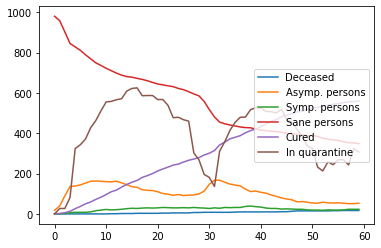

In [9]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import style

init_graph()

fig = plt.figure()
ax = fig.add_subplot()
xs = []
y_D = []
y_MS = []
y_MAS = []
y_S = []
y_G = []
y_Q = []
y_InfectByAS = []

def update_viz():
    xs.append(len(xs))
    y_D.append(nbDead)          # number de deceased
    y_MS.append(nbS)            # number of symptomatic persons 
    y_MAS.append(nbAS)          # number of asymptomatic persons
    y_S.append(nbSane)          # number of sane persons
    y_G.append(nbCured)         # number of cured persons
    y_Q.append(nbQuarantine)    # number of people in quarantine
    y_InfectByAS.append(nbInfectedByAS) # number of people infected by asymp. persons
    
def draw_viz():
    ax.clear()
    def plot_with_label(ys, label):
        line, = ax.plot(xs, ys)
        line.set_label(label)
    plot_with_label(y_D, "Deceased")
    plot_with_label(y_MAS, "Asymp. persons")
    plot_with_label(y_MS, "Symp. persons")
    plot_with_label(y_S, "Sane persons")
    plot_with_label(y_G, "Cured")
    plot_with_label(y_Q, "In quarantine")
    plot_with_label(y_InfectByAS, "Infected by asymp. persons")

    ax.legend(loc='right')

nbSteps = 60
for _ in range(nbSteps):
    # update simulation
    step()
    # update matplotlib
    update_viz()
draw_viz()